<a href="https://colab.research.google.com/github/huerd/GPA659-E2020/blob/howard%2Fprojectx/_project/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Resources*


*   Kernel Visualizations : https://github.com/raghakot/keras-vis
*   Image Files to Numpy Array : https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays
*   MobileNetV2 Dogs/Cats implementation : https://www.kaggle.com/abdallahhassan/dogs-cats-mobilenetv2-transfere-learning








# Per Runtime Setup [Authorization w/ Kaggle database and download]

1.   Set your Kaggle API .JSON file to this runtime
2.   Downloads and extract dogs-vs-cats.zip into two folders



In [15]:
from google.colab import files
import zipfile
# select your Kaggle API kaggle.json
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# make sure to create a kaggle account, get it verified (phone number and all)
# then go accept terms here : https://www.kaggle.com/c/dogs-vs-cats

# zip should be downloaded to /content/
!kaggle competitions download -c dogs-vs-cats

# don't expand the folders unless you want colab to crash on you
# file format is 1.jpg, 2.jpg, etc
unzipTest1 = zipfile.ZipFile("test1.zip", 'r')
unzipTest1.extractall()
unzipTest1.close()

# file format is cat.0.jpg, dog.2.jpg, etc
unzipTrain1 = zipfile.ZipFile("train.zip", 'r')
unzipTrain1.extractall()
unzipTrain1.close()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# Dev Environment Setup

In [16]:
# updates kaggle version
!pip install pillow==7.0.0 
!pip install --upgrade --force-reinstall --no-deps kaggle

from __future__ import print_function

# uncomment below to use version 1.x
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas
import numpy
import os, sys
import IPython.display
import PIL.Image
import random

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


## Constants

In [23]:
IMAGE_WIDTH = 150
IMAGE_LENGTH = 150
IMAGE_SIZE = [IMAGE_WIDTH, IMAGE_LENGTH]
IMAGE_NUMCHANNELS = 3

TRAININGDATASPLIT_RATIO = 09
BATCH_SIZE = 16
EPOCH = 5
SEED = 4

SyntaxError: ignored

# Data Loading

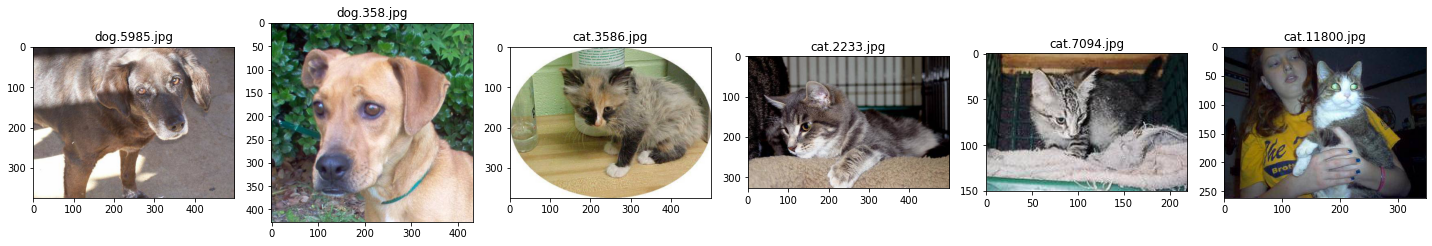

Total Counts from Labeled Data


dog    12500
cat    12500
Name: petType, dtype: int64

In [18]:
labeledData_dir = "train/"
testingData_dir = "test1/"

labeledDataset = os.listdir("train")
testingDataset = os.listdir("test1")

results = []

# loop through our labeledDataset, one file at a time
for eachImage in labeledDataset:
  # recall that our labeledDataset file format is [animal].[num].jpg
  petType = eachImage.split('.')[0]
  if petType == 'cat':
    results.append("cat")
  else:
    results.append("dog")

# df_labeled is where all our labeled data is stored in a DataFrame
df_labeled = pandas.DataFrame({
    'imageName': labeledDataset,
    'petType': results
})

## Visualizations
# create figure size
plt.figure(figsize=(20, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    imageName = random.choice(labeledDataset)
    image = load_img(labeledData_dir + imageName)
    plt.title(imageName)
    plt.imshow(image)
plt.tight_layout()
plt.show()

print("Total Counts from Labeled Data")
df_labeled['petType'].value_counts()

## Splitting training dataset into Training and Validation sets

In [22]:
from sklearn.model_selection import train_test_split

# split your labeled dataset into training and validation sets based on a ratio
# if train_size is 0.3, then training is 70% of the dataset
df_training, df_validation = train_test_split(df_labeled, train_size = TRAININGDATASPLIT_RATIO)

# pandas.DataFrame.shape is a tuple
# https://www.programiz.com/python-programming/methods/tuple
total_dfTraining = df_training.shape
total_dfValidation = df_validation.shape


print("Labeled Data Allocation")
fmt = '{:<4} {:<2} {:<15} '
print(fmt.format("Train :", "", str(total_dfTraining[0])))
print(fmt.format("Valid :", "", str(total_dfValidation[0])))

# ref https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main1.ipynb

Labeled Data Allocation
Train :    2500            
Valid :    22500           


### Preprocessing

Check [ImageDataGenerator] Reference : https://keras.io/api/preprocessing/image/
Its purpose : Used for Data Augmentation - takes the original image, applies a bunch of transforms to the original. The class doesn't change.

*   https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
*   https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb





In [26]:
# playing around here I guess
dg_training = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = dg_training.flow_from_dataframe(
    df_training, 
    directory = "train/", 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    seed = SEED,
    save_to_dir = "aug_train/"
)


batches = train_generator.flow_from_directory('train', 
                                              target_size=(IMAGE_WIDTH,IMAGE_LENGTH),
      class_mode='categorical', 
      batch_size=BATCH_SIZE
      )

x_batch, y_batch = next(batches)

for i in range (0,32):
    image = x_batch[i]
    plt.imshow(image.transpose(2,1,0))
    plt.show()

Found 2500 validated image filenames belonging to 2 classes.


AttributeError: ignored

## Test Data (TODO)

# Model Architecture


*   MobileNet from scratch: https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb

In [ ]:

from IPython.display import SVG

Convert our data to Numpy tables

In [ ]:
# using https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays as reference

print("# of Training data = {0} ".format(len(trainingDataset)) + "images")
print("# of Testing data = {0} ".format(len(testingDataset)) + "images")

training_files =[]
y_train = []
colorChannels = 3

for _eachFile in trainingDataset:
  training_files.append(_eachFile)
  label = _eachFile.find('.')
  y_train.append(_eachFile[0:label])

dataset = numpy.ndarray(shape=(len(training_files), colorChannels),
                     dtype=numpy.float32)

i = 0
for _eachFile in trainingDataset:
    img = Image.open("train/"+_eachFile)  # this is a PIL image
    # Convert to Numpy Array
    x = img_to_array(img)  
    dataset[i] = x
    i += 1


## Model Summary

## Model Visualization

*   Architecture Visualization : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main4.ipynb

# Model Accuracy and Loss graphs

# Confusion Matrix